## Import Libraries

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

## Directory

In [38]:
homepath = "C:/A.PROJECTS/stockprediction/"

## Data

In [39]:
# Read the CSV file
sp500_prices = pd.read_csv(homepath + 'data/sp500_timeseries.txt',sep="\t", parse_dates=['Date'],index_col='Date')
sp500_prices.drop(['ABNB'], axis=1, inplace=True)

In [40]:
def compute_returns(df):
    """
    Computes weekly, monthly, quarterly, and annual simple and log returns
    from a DataFrame of daily adjusted prices.

    Args:
        df (pd.DataFrame): DataFrame with daily adjusted prices. The index should be datetime.

    Returns:
        dict: A dictionary containing DataFrames for weekly, monthly, quarterly, and annual simple and log returns.
    """
    df.dropna(axis=1, inplace=True)
    # Ensure the index is datetime
    if not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError("DataFrame index must be a DatetimeIndex.")

    # Function to calculate simple returns
    def calculate_simple_returns(data):
        return data.pct_change().dropna()

    # Function to calculate log returns
    def calculate_log_returns(data):
        return np.log(data).diff().dropna()

    # Resample data and calculate simple returns
    weekly_simple_returns = calculate_simple_returns(df.resample('W').last())
    monthly_simple_returns = calculate_simple_returns(df.resample('M').last())
    quarterly_simple_returns = calculate_simple_returns(df.resample('Q').last())
    annual_simple_returns = calculate_simple_returns(df.resample('Y').last())

    # Resample data and calculate log returns
    weekly_log_returns = calculate_log_returns(df.resample('W').last())
    monthly_log_returns = calculate_log_returns(df.resample('M').last())
    quarterly_log_returns = calculate_log_returns(df.resample('Q').last())
    annual_log_returns = calculate_log_returns(df.resample('Y').last())

    return {
        'weekly_simple': weekly_simple_returns,
        'monthly_simple': monthly_simple_returns,
        'quarterly_simple': quarterly_simple_returns,
        'annual_simple': annual_simple_returns,
        'weekly_log': weekly_log_returns,
        'monthly_log': monthly_log_returns,
        'quarterly_log': quarterly_log_returns,
        'annual_log': annual_log_returns
    }

In [41]:
rets = compute_returns(sp500_prices)
rets['weekly_log'].shape

(261, 462)

## PCA clustering

Explained variance by top 5 components: [0.09490474 0.08319444 0.04187378 0.02760561 0.02722505]


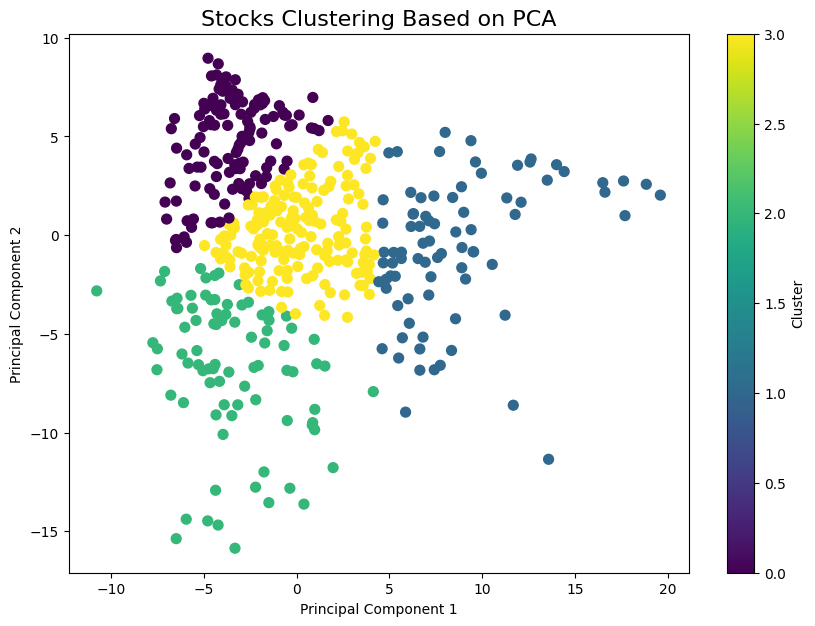

Cluster 0: ABBV, ABT, AEE, AEP, ALL, AMCR, AMT, AWK, LNT, MO, AJG, AMGN, AON, ATO, AZO, BAX, BDX, T, CAG, CB, CBOE, CHD, CHTR, CI, CL, CLX, CMCSA, CME, CMS, CNC, CNP, COR, CSCO, KO, CCI, COST, CVS, DG, DHR, DLR, ED, D, DLTR, DPZ, DTE, DUK, EA, EIX, ELV, EQIX, ERIE, ETR, ES, EVRG, EXC, FDS, FE, GILD, GIS, HRL, HSY, HUM, INCY, JKHY, JNJ, K, KDP, KHC, KMB, KR, LH, LLY, LMT, MAA, MCD, MCK, MDLZ, MKC, MMC, MNST, MOH, MRK, NEE, NEM, NI, NOC, ORLY, PEG, PEP, PFE, PG, PGR, PM, PNW, PPL, PSA, DGX, O, REGN, ROL, ROP, RSG, SBAC, SJM, SRE, SO, STE, TMO, TMUS, TSCO, TRV, TSN, UNH, VRSK, VRSN, VRTX, VZ, WRB, WEC, WM, WMT, WTW, XEL, ZTS
Cluster 1: AIG, ALB, AXP, APA, APTV, BAC, BKR, C, CE, CF, CFG, COP, CVX, SCHW, CTRA, CTVA, DAL, DFS, DVN, FANG, DOW, EMN, EOG, EQT, EXPE, F, FCX, FITB, GE, XOM, GM, HAL, HES, HST, HWM, HBAN, IVZ, JPM, KEY, KIM, KMI, LYB, LYV, MPC, MTB, MAR, MET, MGM, MHK, MOS, NCLH, NUE, OKE, OXY, PARA, PFG, PNC, PRU, PSX, RCL, RF, RJF, RL, SLB, SPG, LUV, STLD, STT, SYF, TPL, TPR, TRG

In [42]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

df = rets['weekly_log']
stock_names = df.columns

# Step 1: Normalize the data (transpose before scaling)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df.T).T # Scale each stock's returns

# Step 2: Apply PCA
pca = PCA(n_components=5)  # Project into 5 principal components
pca_result = pca.fit_transform(scaled_data.T) # PCA on stocks
print(f"Explained variance by top 5 components: {pca.explained_variance_ratio_}")

# Use the first 2 components for visualization
pca_data_2D = pca_result[:, :2]

# Step 3: Cluster using K-Means
n_clusters = 4  # Define the number of clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
clusters = kmeans.fit_predict(pca_data_2D)

# Create a DataFrame for the PCA results and cluster assignments
pca_df = pd.DataFrame(pca_result)
pca_df['Cluster'] = clusters
pca_df['Stock'] = stock_names

# Step 4: Visualize the Clusters
plt.figure(figsize=(10, 7))
plt.scatter(pca_data_2D[:, 0], pca_data_2D[:, 1], c=clusters, cmap="viridis", s=50)
plt.title("Stocks Clustering Based on PCA", fontsize=16)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label="Cluster")
plt.show()


ClusterList_PCA = []
# Step 5: List clusters
for cluster in range(n_clusters):
    cluster_stocks = pca_df[pca_df['Cluster'] == cluster]['Stock']
    ClusterList_PCA.append(cluster_stocks)
    print(f"Cluster {cluster}: {', '.join(cluster_stocks.values)}")
ClusterDict_PCA = {
    'Cluster01':ClusterList_PCA[0],
    'Cluster02':ClusterList_PCA[1],
    'Cluster03':ClusterList_PCA[2],
    'Cluster04':ClusterList_PCA[3]
}

## DTW Clustering <span style="font-size:20px">(dynamic time warping)</span>

### **DTW**: Hierarchical Approach
#### (No default number of clusters)

Computing DTW distance matrix (parallelized)...
DTW matrix computation complete!


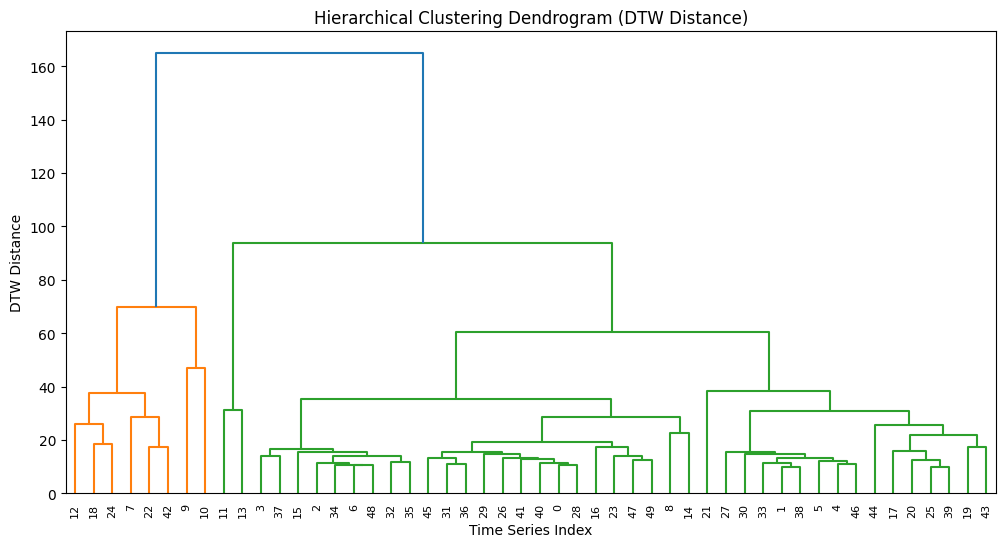

In [67]:
import numpy as np
import matplotlib.pyplot as plt
from fastdtw import fastdtw
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, dendrogram
from joblib import Parallel, delayed  # For parallel DTW computation


time_series_data = rets['weekly_log']
time_series_data = [row.values for _, row in time_series_data.iterrows()]

# 2. Compute DTW Distance Matrix with Parallel Processing
def dtw_distance(i, j, ts_data):
    distance, _ = fastdtw(ts_data[i], ts_data[j])
    return (i, j, distance)

print("Computing DTW distance matrix (parallelized)...")
dtw_results = Parallel(n_jobs=-1)(delayed(dtw_distance)(i, j, time_series_data)
                                  for i in range(num_series) for j in range(i + 1, num_series))

# Convert results into a symmetric distance matrix
dtw_matrix = np.zeros((num_series, num_series))
for i, j, dist in dtw_results:
    dtw_matrix[i, j] = dist
    dtw_matrix[j, i] = dist  # Symmetric

print("DTW matrix computation complete!")

# 3. Convert Distance Matrix to Condensed Format
dtw_condensed = squareform(dtw_matrix)

# 4. Apply Hierarchical Clustering
linkage_matrix = linkage(dtw_condensed, method="ward")

# 5. Plot Fixed Dendrogram
plt.figure(figsize=(12, 6))
dendrogram(linkage_matrix, labels=[str(i) for i in range(num_series)], leaf_rotation=90)
plt.title("Hierarchical Clustering Dendrogram (DTW Distance)")
plt.xlabel("Time Series Index")
plt.ylabel("DTW Distance")
plt.show()


In [78]:
""" Because hierarchical dtw number of clusters
    cannot be determined beforehand, one can trim
    the diagram and reach to its desired number of
    clusters, using fcluster function.
"""

from scipy.cluster.hierarchy import fcluster

# Apply hierarchical clustering
linkage_matrix = linkage(squareform(dtw_matrix), method="ward")

# Specify number of clusters
num_clusters = 4  # Change as needed
labels = fcluster(linkage_matrix, num_clusters, criterion="maxclust")

# Print cluster assignments
for cluster in range(1, num_clusters + 1):
    print(f"Cluster {cluster}: {np.where(labels == cluster)[0]}")


Cluster 1: [  4  11  13  16  17  19  20  21  25  27  30  33  38  39  43  44  46  47
  52  56  57  60  61  69  76  85  95 100 114 124 128 132 133 135 139 143
 145 146 148 157 159 168 181 199 201 203 205 235 240 244 252 254]
Cluster 2: [ 9 10]
Cluster 3: [  0   1   5   6  15  23  26  28  29  31  32  36  40  41  45  48  49  50
  51  53  54  58  62  64  65  66  67  68  70  71  72  73  74  77  78  80
  81  82  83  86  88  89  90  91  92  93  94  96  97 102 103 105 107 108
 109 111 115 116 118 125 130 131 134 136 150 151 154 155 156 158 160 161
 162 164 167 170 171 172 174 175 176 177 178 179 182 183 184 185 187 189
 190 192 194 196 200 202 204 206 207 209 210 211 212 213 214 215 216 217
 218 219 220 221 224 225 226 227 228 229 230 231 232 233 234 236 239 241
 242 245 246 247 248 249 255 256 259 260]
Cluster 4: [  2   3   7   8  12  14  18  22  24  34  35  37  42  55  59  63  75  79
  84  87  98  99 101 104 106 110 112 113 117 119 120 121 122 123 126 127
 129 137 138 140 141 142 144 147 149 

### **DTW**: K-mean Approach 
#### (with default number of clusters)

Computing DTW distance matrix in parallel...
DTW matrix computation complete!
Clustering into 4 clusters using parallelized K-Medoids...
Cluster 0: [2, 3, 7, 8, 12, 15, 18, 22, 24, 32, 34, 35, 37, 42, 55, 59, 62, 70, 75, 79, 84, 87, 90, 97, 98, 99, 101, 104, 106, 110, 112, 113, 117, 118, 119, 120, 121, 122, 123, 125, 126, 127, 129, 131, 136, 137, 138, 140, 141, 142, 144, 147, 149, 152, 153, 158, 161, 163, 165, 166, 169, 173, 174, 176, 180, 186, 188, 191, 193, 195, 197, 198, 200, 208, 218, 221, 222, 223, 228, 236, 238, 243, 250, 251, 253, 256, 257, 258]
Cluster 1: [9, 10]
Cluster 2: [4, 11, 13, 17, 19, 20, 21, 25, 27, 30, 33, 38, 39, 43, 44, 46, 47, 52, 56, 57, 60, 61, 69, 76, 85, 95, 100, 114, 124, 128, 132, 133, 135, 139, 143, 145, 146, 148, 156, 157, 168, 179, 181, 199, 201, 203, 205, 235, 240, 244, 252, 254]
Cluster 3: [0, 1, 5, 6, 14, 16, 23, 26, 28, 29, 31, 36, 40, 41, 45, 48, 49, 50, 51, 53, 54, 58, 63, 64, 65, 66, 67, 68, 71, 72, 73, 74, 77, 78, 80, 81, 82, 83, 86, 88, 89, 91, 9

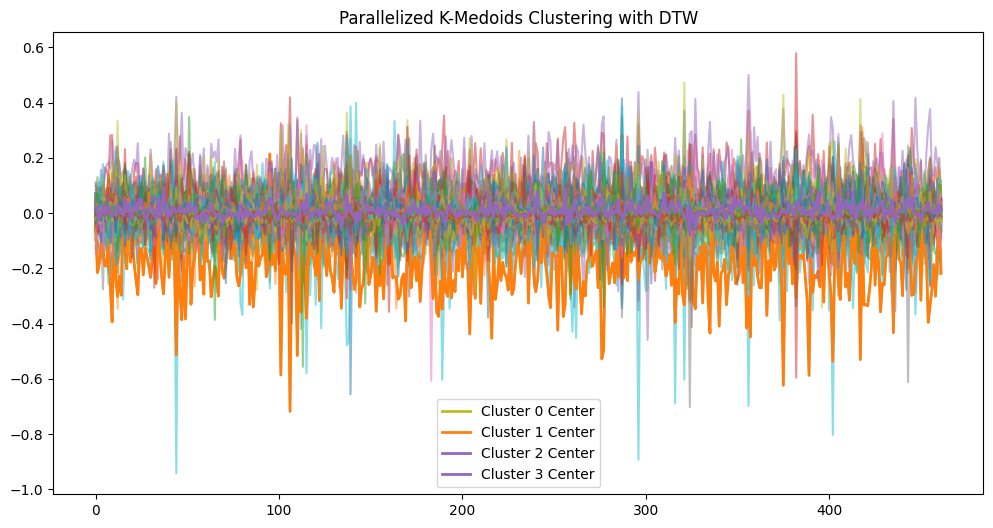

In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyclustering.cluster.kmedoids import kmedoids
from tslearn.metrics import dtw
from joblib import Parallel, delayed  # For parallel computation

# Example DataFrame (Replace this with your actual data)
df = rets['weekly_log']

# Convert DataFrame to list of time series
time_series_data = [row.values for _, row in df.iterrows()]
time_series_data = np.array(time_series_data)  # Convert to NumPy array

# Specify number of clusters
num_clusters = 4

# Function to compute DTW between two time series
def compute_dtw(i, j, ts_data):
    return dtw(ts_data[i], ts_data[j])

# Parallelized DTW distance matrix computation
print("Computing DTW distance matrix in parallel...")
num_series = len(time_series_data)
dtw_matrix = np.zeros((num_series, num_series))

dtw_results = Parallel(n_jobs=-1)(
    delayed(compute_dtw)(i, j, time_series_data)
    for i in range(num_series) for j in range(i + 1, num_series)
)

# Fill the symmetric matrix
index = 0
for i in range(num_series):
    for j in range(i + 1, num_series):
        dtw_matrix[i, j] = dtw_results[index]
        dtw_matrix[j, i] = dtw_results[index]
        index += 1

print("DTW matrix computation complete!")

# Select initial medoid indices randomly
initial_medoids = np.random.choice(range(num_series), num_clusters, replace=False)

# Apply K-Medoids Clustering (pyclustering)
print(f"Clustering into {num_clusters} clusters using parallelized K-Medoids...")
kmedoids_instance = kmedoids(dtw_matrix, initial_medoids, data_type="distance_matrix")
kmedoids_instance.process()
clusters = kmedoids_instance.get_clusters()
medoids = kmedoids_instance.get_medoids()

# Assign labels to each time series
labels = np.zeros(num_series)
for cluster_idx, cluster in enumerate(clusters):
    for index in cluster:
        labels[index] = cluster_idx

# Print cluster assignments
for cluster_idx, cluster in enumerate(clusters):
    print(f"Cluster {cluster_idx}: {cluster}")

# Plot representative time series for each cluster
plt.figure(figsize=(12, 6))
for cluster_idx, cluster in enumerate(clusters):
    for ts_idx in cluster:
        plt.plot(time_series_data[ts_idx], alpha=0.5)
    plt.plot(time_series_data[medoids[cluster_idx]], linewidth=2, label=f"Cluster {cluster_idx} Center")

plt.legend()
plt.title("Parallelized K-Medoids Clustering with DTW")
plt.show()


### **DTW**: Cohesion and Separation

In [88]:
""" 
Cohesion (intra cluster - Lower is better)

    If Cluster A: **5.12** → Means time series in Cluster 0 are closely related.

    If Cluster A: **20.45** → Means Cluster 1 is much more spread out.


Separation (inter clusters - Higher is better)

    If Separation(A, B) = **30.25** → Clusters 0 and 1 are well-separated.

    If Separation(A, C) = **5.8** → Clusters 0 and 2 are similar and might need re-evaluating.
"""

import numpy as np
from tslearn.metrics import dtw

# Function to compute cohesion (similarity within a cluster)
def compute_cohesion(cluster, time_series_data):
    if len(cluster) < 2:
        return 0  # If only one element, no cohesion measure
    total_dtw = sum(dtw(time_series_data[i], time_series_data[j]) 
                    for i in cluster for j in cluster if i != j)
    return total_dtw / (len(cluster) * (len(cluster) - 1))

# Function to compute separation (difference between clusters)
def compute_separation(medoids, time_series_data):
    num_clusters = len(medoids)
    separation_values = np.zeros((num_clusters, num_clusters))
    for i in range(num_clusters):
        for j in range(i + 1, num_clusters):
            separation_values[i, j] = dtw(time_series_data[medoids[i]], time_series_data[medoids[j]])
            separation_values[j, i] = separation_values[i, j]  # Symmetric matrix
    return separation_values

# Compute cohesion for each cluster
cohesion_values = {cluster_idx: compute_cohesion(cluster, time_series_data) 
                   for cluster_idx, cluster in enumerate(clusters)}

# Compute separation between clusters
separation_matrix = compute_separation(medoids, time_series_data)

# Print results
print("\nCohesion (Intra-Cluster Similarity):")
for cluster_idx, cohesion in cohesion_values.items():
    print(f"Cluster {cluster_idx}: {cohesion:.2f}")

print("\nSeparation (Inter-Cluster Difference):")
print(separation_matrix)



Cohesion (Intra-Cluster Similarity):
Cluster 0: 0.75
Cluster 1: 1.99
Cluster 2: 0.83
Cluster 3: 0.58

Separation (Inter-Cluster Difference):
[[0.         2.9007485  0.7674367  0.54206229]
 [2.9007485  0.         4.13460156 3.68802277]
 [0.7674367  4.13460156 0.         0.52009431]
 [0.54206229 3.68802277 0.52009431 0.        ]]


## Gaussian Mixture Model

In [ ]:
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Step 1: Time Series Generator Class
class TimeSeriesGenerator:
    def __init__(self, num_series, num_points, random_seed=42):
        self.num_series = num_series
        self.num_points = num_points
        self.random_seed = random_seed

    def generate(self):
        np.random.seed(self.random_seed)
        data = []
        for i in range(self.num_series):
            trend = i * 0.1 * np.arange(self.num_points)  # Adding a trend
            seasonality = 5 * np.sin(np.linspace(0, 2 * np.pi, self.num_points))  # Adding seasonality
            noise = np.random.normal(0, 1, self.num_points)  # Adding random noise
            time_series = trend + seasonality + noise
            data.append(time_series)
        return np.array(data)

# Step 2: Preprocessing Class
class TimeSeriesPreprocessor:
    def __init__(self, scaler=None):
        self.scaler = scaler if scaler else StandardScaler()

    def fit_transform(self, data):
        return self.scaler.fit_transform(data)

    def inverse_transform(self, scaled_data):
        return self.scaler.inverse_transform(scaled_data)

# Step 3: GMM Clustering Class
class GMMClusterer:
    def __init__(self, num_clusters, covariance_type='full', random_state=42):
        self.num_clusters = num_clusters
        self.covariance_type = covariance_type
        self.random_state = random_state
        self.model = GaussianMixture(n_components=num_clusters, covariance_type=covariance_type, random_state=random_state)

    def fit(self, data):
        self.model.fit(data)

    def predict(self, data):
        return self.model.predict(data)

    def get_cluster_centers(self, data, labels):
        # Compute the mean (centroid) of each cluster manually
        cluster_centers = []
        for cluster in range(self.num_clusters):
            cluster_data = data[labels == cluster]
            cluster_centers.append(cluster_data.mean(axis=0))
        return np.array(cluster_centers)

# Step 4: Visualization Class
class TimeSeriesVisualizer:
    @staticmethod
    def plot_clusters(time_series_data, labels, num_clusters):
        plt.figure(figsize=(10, 6))
        for cluster in range(num_clusters):
            cluster_indices = np.where(labels == cluster)[0]
            for idx in cluster_indices:
                plt.plot(time_series_data[idx], alpha=0.6)
            plt.plot(
                np.mean(time_series_data[cluster_indices], axis=0), 
                label=f'Cluster {cluster} mean', 
                linewidth=2.5
            )
        plt.title("Time Series Clustering using Gaussian Mixture Model")
        plt.xlabel("Time Step")
        plt.ylabel("Value")
        plt.legend()
        plt.show()

# Step 5: Putting it All Together in a Pipeline
if __name__ == '__main__':
    # Configuration
    num_series = 50       # Number of time series
    num_points = 100      # Length of each time series
    num_clusters = 3      # Desired number of clusters

    # 1. Generate synthetic time series data
    generator = TimeSeriesGenerator(num_series=num_series, num_points=num_points)
    time_series_data = generator.generate()

    # 2. Preprocess data
    preprocessor = TimeSeriesPreprocessor()
    scaled_data = preprocessor.fit_transform(time_series_data)

    # 3. Perform clustering using Gaussian Mixture Model
    clusterer = GMMClusterer(num_clusters=num_clusters)
    clusterer.fit(scaled_data)
    labels = clusterer.predict(scaled_data)

    # 4. Visualize clusters
    visualizer = TimeSeriesVisualizer()
    visualizer.plot_clusters(time_series_data, labels, num_clusters)
